# Load dataset and packages

In [ ]:
!pip install category_encoders==2.*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import xgboost as xgb

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
! pip install -q kaggle 
#to force update Kaggle API
#!pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#if Google Drive mounted with API credential
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#to check if API is working
#! kaggle datasets list

! kaggle competitions download -c ieee-fraud-detection

mkdir: cannot create directory ‘/root/.kaggle’: File exists
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip train_identity.csv.zip
!unzip train_transaction.csv.zip

Archive:  test_identity.csv.zip
  inflating: test_identity.csv       
Archive:  test_transaction.csv.zip
  inflating: test_transaction.csv    
Archive:  train_identity.csv.zip
  inflating: train_identity.csv      
Archive:  train_transaction.csv.zip
  inflating: train_transaction.csv   


In [3]:
folder_path = '/content/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')

#merge transaction and identity tables
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

#Explorative data analysis

In [ ]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
print(f'Shape of training dataset: {train.shape}')
print(f'Columns with null values: {train.isnull().any().sum()}\n')

print(f'Example feature value counts: \n{train.V6.value_counts(dropna=False, normalize=True).head()}\n')
print(f'{train.C10.value_counts(dropna=False, normalize=True).head()}')

Shape of training dataset: (590540, 434)
Columns with null values: 414

Shape of testing dataset: (506691, 433)
Columns with null values: 385

Example feature value counts: 
1.0    0.505685
NaN    0.472935
2.0    0.019167
3.0    0.001768
4.0    0.000305
Name: V6, dtype: float64

0.0    0.767843
1.0    0.169728
2.0    0.025295
3.0    0.010866
4.0    0.004802
Name: C10, dtype: float64


In [10]:
# close previous plots
plt.close('all')
%matplotlib inline

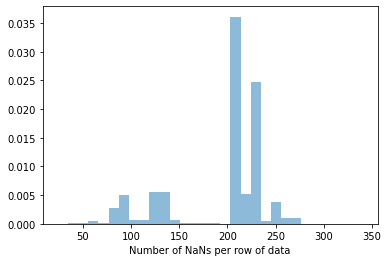

In [11]:
train_null = train.isnull().sum(axis=1)
test_null = test.isnull().sum(axis=1)
plt.hist(train_null, density = True, bins=30, alpha=.5)
plt.xlabel('Number of NaNs per row of data');


In [ ]:
print(f'Target column (isFraud) has {train.isFraud.isnull().sum()} null values.\n')
print(f'Class proportion: \n{train.isFraud.value_counts(normalize=True)}')

isFraud column has 0 null values.

isFraud column class proportion: 
0    0.96501
1    0.03499
Name: isFraud, dtype: float64


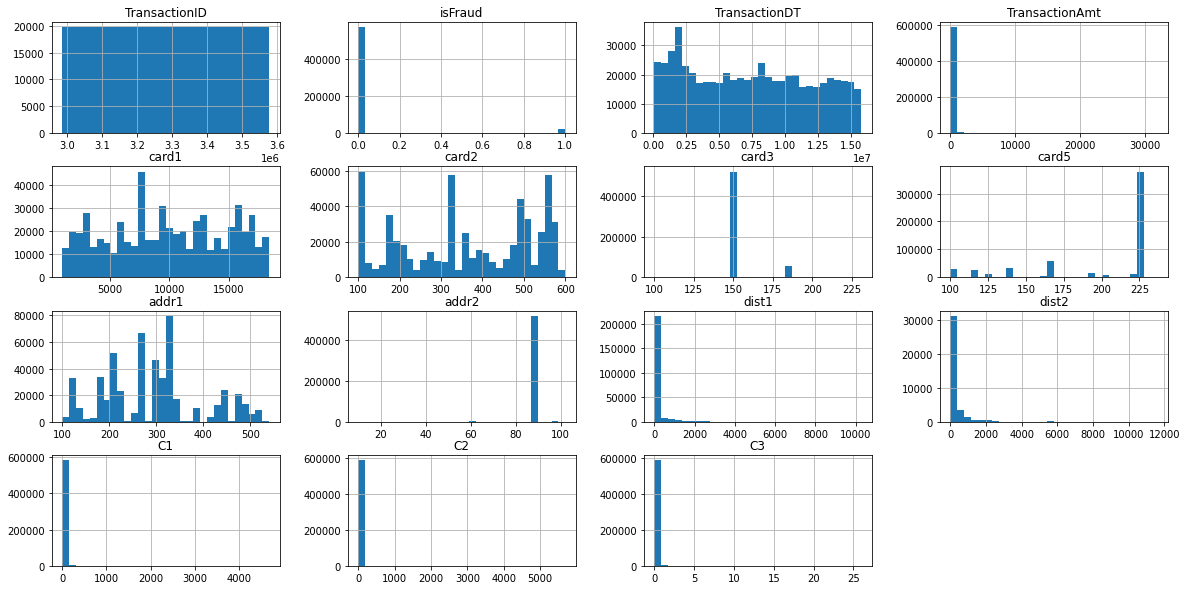

In [ ]:
train[list(train.columns[:20])].hist(bins=30, figsize=(20, 10));

In [13]:
#check if any columns with only 1 unique value
len([col for col in train.columns if train[col].nunique() == 1])

0

In [4]:
target = 'isFraud'
# Split into train and validation data 
y = train[target]
X = train.drop(columns= target).fillna(-999)
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state = 42)

#XGBoost

In [7]:

xgbclf = make_pipeline(OrdinalEncoder(),
                       SimpleImputer(strategy='mean'),
                       xgb.XGBClassifier(
                          n_estimators=1000,
                          max_depth=9,
                          learning_rate=0.05,
                          subsample=0.9,
                          colsample_bytree=0.9,
                          missing=-999,
                          random_state=2019,
                          tree_method='gpu_hist'
                            ))

%time xgbclf.fit(X_train, y_train)

CPU times: user 59.1 s, sys: 1.76 s, total: 1min
Wall time: 1min


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['ProductCD', 'card4', 'card6',
                                      'P_emaildomain', 'R_emaildomain', 'M1',
                                      'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8',
                                      'M9', 'id_12', 'id_15', 'id_16', 'id_23',
                                      'id_27', 'id_28', 'id_29', 'id_30',
                                      'id_31', 'id_33', 'id_34', 'id_35',
                                      'id_36', 'id_37', 'id_38', 'DeviceType', ...],
                                mapping=[{'col': 'ProductCD',
                                          'data_type': dtype('O'),
                                          '...
                                          'data_type': dtype('O'),
                                          'mapping': -999    1
F       2
T       3
NaN    -2
dtype: int64},
                                         {'col': 'DeviceType',
           

In [8]:
val = xgbclf.predict_proba(X_val)[:,-1]
roc_auc_score(y_val, val)

0.9735826926284469